# Twitter Sentiment Analysis

En el presente notebook, se tiene como objetivo el conseguir un buen modelo de análisis de sentimientos basado en tweets. Al final, como de todos es sabido, Twitter es una fuente de información a gran escala que puede llegar a ser considerado un reflejo de la realidad social que se vive dia a dia, por lo que el ser capaces de extraer y analizar informacion relevante al respecto es crucial en terminos de generacion de valor. 

In [1]:
# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

# PREPROCESAMIENTO

En primer lugar, cargamos el dataset de trabajo, que corresponde con el dataset conocido comon Sentiment140 en Kaggle, en el que disponemos de un total de 1.6 millones de tweets etiquetados con 0 (negativo) o 4 (positivo).

Mostramos 5 registros del dataframe para hacernos una idea del tipo de dato con el que se va a trabajar.

In [2]:
# Importing the dataset
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('training.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.sample(5)

,target,ids,date,flag,user,text
828553,4,1557033226,Sun Apr 19 01:38:29 PDT 2009,NO_QUERY,slmay,@vesselproject the broken-hearted hear from Go...
500974,0,2187018010,Mon Jun 15 19:40:13 PDT 2009,NO_QUERY,pixielaine,Has never been this fat since 18 gosh~~~
1047659,4,1958066489,Fri May 29 02:32:43 PDT 2009,NO_QUERY,taraw07,is amazed at all the crap found while cleaning...
1504453,4,2072171403,Sun Jun 07 20:31:38 PDT 2009,NO_QUERY,noralmt,@peely22 fair enough-became your 30th follower
1426242,4,2059184000,Sat Jun 06 16:25:04 PDT 2009,NO_QUERY,AshleyyMercer,Having a relaxing evening.. My workin man dese...


In [3]:
print('length of data is', len(df))

length of data is 1600000


Sacamos información genérica del dataset: 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [5]:
df.dtypes

target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

Realizamos un análisis de los valores únicos de nuestra variable objetivo:

In [6]:
#Unique target values
df['target'].unique()

array([0, 4], dtype=int64)

In [7]:
df['target'].nunique()

2

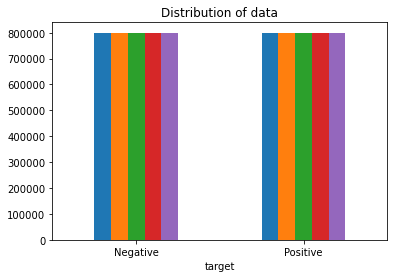

In [8]:
# Distribución de las clases
# Negative es el 0 y Positive el 4
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
text, sentiment = list(df['text']), list(df['target'])

<AxesSubplot:xlabel='target', ylabel='count'>

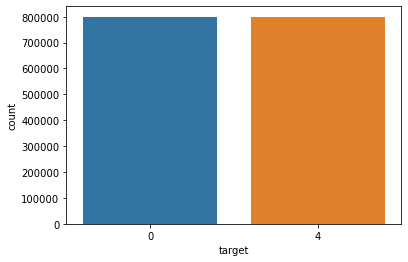

In [9]:
import seaborn as sns
sns.countplot(x='target', data=df)

En ambos gráficos, podemos ver que las clases estan balanceadas, lo que a priori no debería preocuparnos de cara al entrenamiento y la confección de los diferentes modelos a emplear. 

In [10]:
data=df[['text','target']]

In [11]:
#el positivo en vez de a 4 lo asociamos al 1, para que sea una clasificación binaria tradicional [0,1]
data['target'] = data['target'].replace(4,1)

C:\Users\usuario\AppData\Local\Temp\ipykernel_21304\1507411727.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['target'].replace(4,1)


In [12]:
#Visualizamos como han quedado los datos estructurados
data

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0
...,...,...
1599995,Just woke up. Having no school is the best fee...,1
1599996,TheWDB.com - Very cool to hear old Walt interv...,1
1599997,Are you ready for your MoJo Makeover? Ask me f...,1
1599998,Happy 38th Birthday to my boo of alll time!!! ...,1


In [13]:
data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]

In [14]:
# Pillamos una muestra de 40.000 de cada clase
# Orientado a que no haya problemas de computación
# Y teniendo en cuenta en todo momento que los resultados en los modelos
# Se verán afectados tambien por esta decisión
data_pos = data_pos.iloc[:int(40000)]
data_neg = data_neg.iloc[:int(40000)]

In [15]:
#Volvemos a unirlo en 1
dataset = pd.concat([data_pos, data_neg])

## Pasamos el texto de los tweets a letra minúscula

In [16]:
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

39995    have a quiz in spanish class tonday ..  but i ...
39996    @mittec no problems with it as such but i had ...
39997                                          ow my head 
39998    anyway... not particularly looking foreward to...
39999    allergies or insomnia? doesn't matter the reason 
Name: text, dtype: object

## Procesamiento de Stopwords

In [17]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [18]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

800000                love @health4uandpets u guys r best!!
800001    im meeting one besties tonight! cant wait!! - ...
800002    @darealsunisakim thanks twitter add, sunisa! g...
800003    sick really cheap hurts much eat real food plu...
800004                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

## Limpiar puntuaciones

In [19]:
import string
english_punctuations = string.punctuation

In [20]:
def cleaning_punctuations(text):
    translator = str.maketrans('', '', english_punctuations)
    return text.translate(translator)

In [21]:
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

39995            quiz spanish class tonday  but think pass
39996    mittec no problems but literally spent 2 hours...
39997                                              ow head
39998    anyway not particularly looking foreward labs ...
39999              allergies insomnia doesnt matter reason
Name: text, dtype: object

## Eliminar repetidos que sean información redundante

In [22]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

39995            quiz spanish class tonday  but think pass
39996    mittec no problems but literally spent 2 hours...
39997                                              ow head
39998    anyway not particularly looking foreward labs ...
39999              allergies insomnia doesnt matter reason
Name: text, dtype: object

## Eliminar URLs a partir de Regular Expressions

In [23]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

39995            quiz spanish class tonday  but think pass
39996    mittec no problems but literally spent 2 hours...
39997                                              ow head
39998    anyway not particularly looking foreward labs ...
39999              allergies insomnia doesnt matter reason
Name: text, dtype: object

## Limpiar y eliminar valores numericos

In [24]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()

39995            quiz spanish class tonday  but think pass
39996    mittec no problems but literally spent  hours ...
39997                                              ow head
39998    anyway not particularly looking foreward labs ...
39999              allergies insomnia doesnt matter reason
Name: text, dtype: object

## Efectuamos la tokenizacion de los tweets

In [25]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].tail()

39995     [quiz, spanish, class, tonday, but, think, pass]
39996    [mittec, no, problems, but, literally, spent, ...
39997                                           [ow, head]
39998    [anyway, not, particularly, looking, foreward,...
39999        [allergies, insomnia, doesnt, matter, reason]
Name: text, dtype: object

## Aplicar Stemming

Reducción de las palabras a su raíz

In [26]:
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, cant, wai...
800002    [darealsunisakim, thanks, twitter, add, sunisa...
800003    [sick, really, cheap, hurts, much, eat, real, ...
800004                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

## Aplicamos Lemmatization

In [27]:
# Hacemos uso del lexical database conocido como wordnet y omw para la lemmatizacion
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [28]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, cant, wai...
800002    [darealsunisakim, thanks, twitter, add, sunisa...
800003    [sick, really, cheap, hurts, much, eat, real, ...
800004                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

## Separamos input feature y el label

In [29]:
X=data.text
y=data.target

## Graficamos nube de palabras tanto de los tweets negativos como positivos

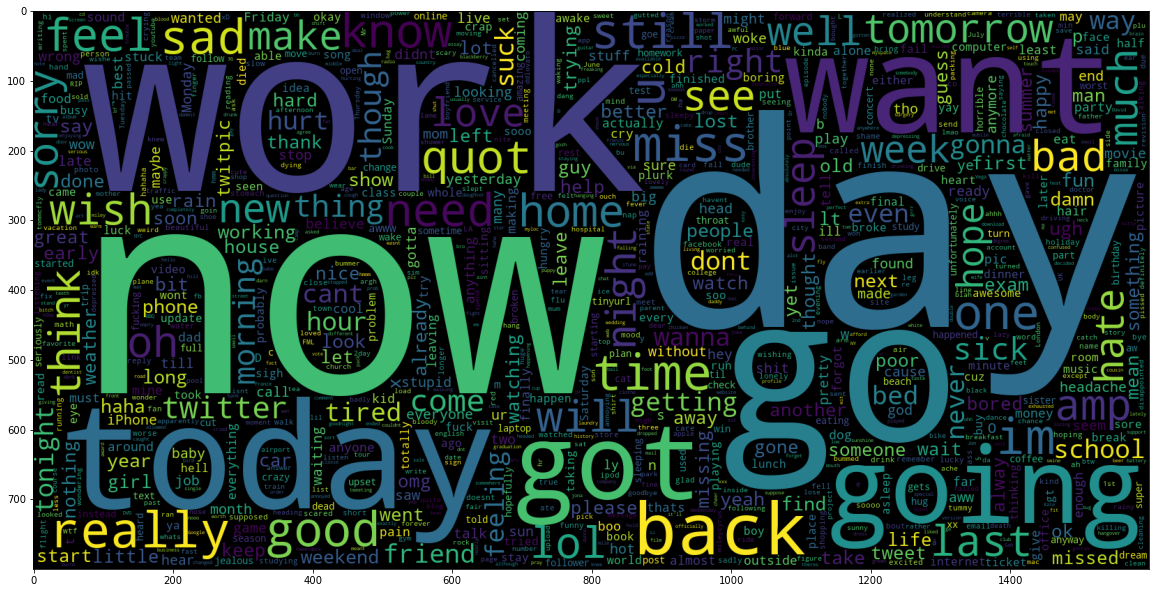

In [30]:
# Tweets clasificados como negativos
data_neg = data['text'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

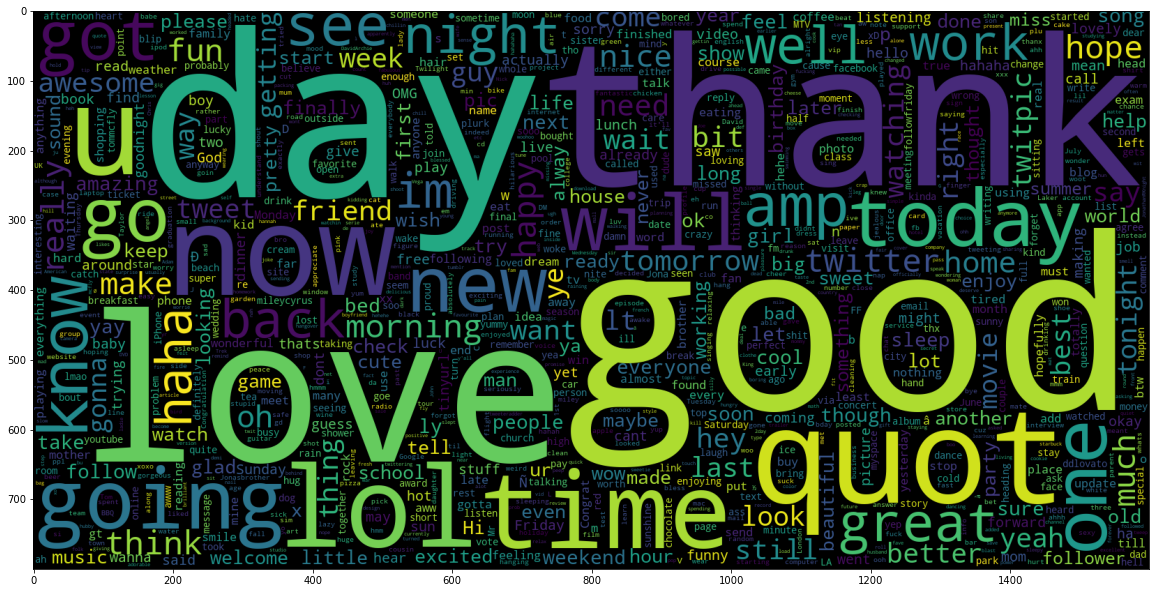

In [31]:
# Tweets clasificados como positivos
data_pos = data['text'][800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

En ambos casos, vemos que las palabras más frecuentadas en tweets tanto con una connotación positiva como negativa tiene sentido que aparezcan como se ha visto en las 2 representaciones anteriores. Al final, son palabras que de por si o solas o junto con otras suelen ir acompañadas de un mensaje con una connotación determinada. 

## ENTRENAMIENTO

## Separacion en entrenamiento y test

In [32]:
# 95% training y 5% testing
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =26105111)

## Uso del TF-IDF Vectorizer

In [33]:
#Metemos:
## ngram_range : El límite inferior y superior del rango de valores n para los diferentes n-grams a extraer
## max_features : Construir un vocabulario que sólo tenga en cuenta los max_features ordenados por la frecuencia de los términos en el corpus
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

C:\Users\usuario\anaconda3\envs\text\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


No. of feature_words:  500000


In [37]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [38]:
X_train

<1520000x500000 sparse matrix of type '<class 'numpy.float64'>'
	with 30119217 stored elements in Compressed Sparse Row format>

Una vez tenemos la entrada preparada para los diferentes modelos a emplear, procedemos a su entrenamiento

## Model-1 : Naive Bayes for multivariate Bernoulli models

In [39]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)

BernoulliNB()

In [40]:
y_pred1 = BNBmodel.predict(X_test)

## Model-2 : Linear Support Vector Classification

In [41]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)

LinearSVC()

In [42]:
y_pred2 = SVCmodel.predict(X_test)

## Model-3 : Logistic Regression

In [43]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)

LogisticRegression(C=2, max_iter=1000, n_jobs=-1)

In [44]:
y_pred3 = LRmodel.predict(X_test)

## EVALUACION

Evaluaremos los siguientes parámetros para evaluar la performance del modelo:
- Accuracy
- Matriz de confusion
- Curva ROC

In [45]:
from sklearn.metrics import roc_curve, auc

In [46]:
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

## Model 1

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     40100
           1       0.80      0.81      0.80     39900

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



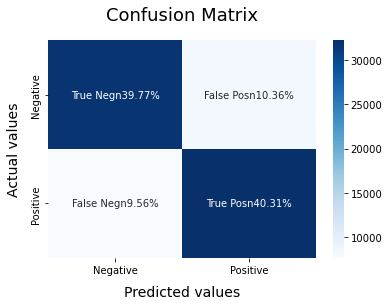

In [47]:
model_Evaluate(BNBmodel)

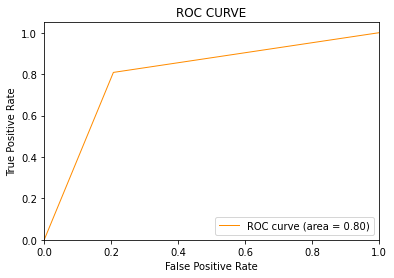

In [48]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

## Model 2

              precision    recall  f1-score   support

           0       0.82      0.81      0.81     40100
           1       0.81      0.82      0.82     39900

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



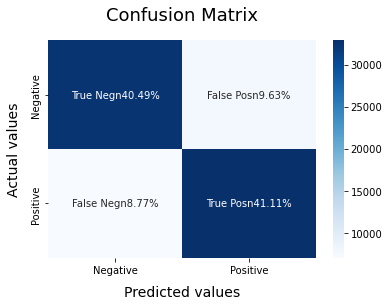

In [49]:
model_Evaluate(SVCmodel)

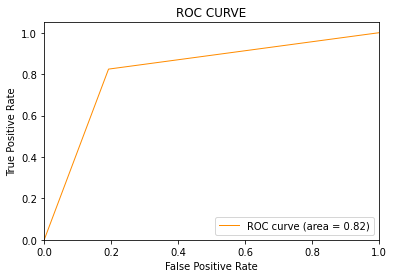

In [50]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

## Model 3

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     40100
           1       0.82      0.84      0.83     39900

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



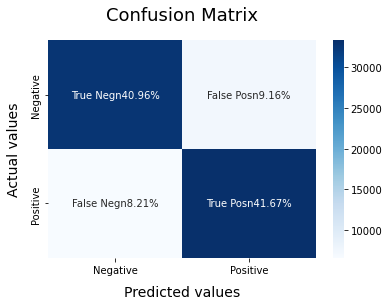

In [51]:
model_Evaluate(LRmodel)

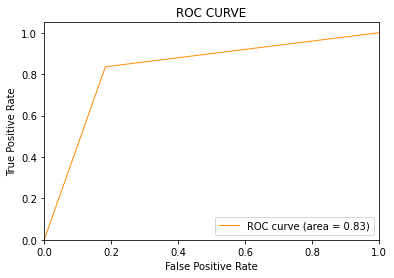

In [52]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

Después de haber entrenado los 3 modelos mencionados y obtener los resultados de la evaluación, procederemos en el próximo apartado con la conclusión y selección del mejor modelo dadas las caracaterísticas del problema planteado. 

# CONCLUSION

En cuanto a los resultados obtenidos, está claro que los mejores han sido los que se han conseguido con la Regresión Logística, ya que las métricas obtenidas de la matriz de confusión han sido mejores que las del SVM, y estas mejores que el Bernoulli Naive Bayes. 

Aparte, la curva ROC tambien alcanza un mayor Area para el set de testeo en la Regresión Logística, lo que también , de alguna forma, secunda lo que comentabamos en un principio. 

## SELECCIÓN DEL MODELO e INFERENCIA

El mejor modelo ha sido el SVM, por lo que será para el que se aplique la función de inferencia, aunque si se quiere, se puede utilizar la función con otro modelo que haya sido previamente cargado. 

In [53]:
tweetExample = "Good to know! You are the first"

In [60]:
def predictSentiment(model,tweetText):
    X  = vectoriser.transform([tweetText])
    y = model.predict(X)
    if (y[0]==1):
        res = "Positive"
    else:
        res = "Negative"
        
    return res

Ejemplo de uso de la función: 

In [61]:
predictSentiment(LRmodel,tweetExample)

'Positive'